In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

params = {'legend.fontsize': 20,
          'figure.figsize': (12, 8),
          'axes.labelsize': 20,
          'axes.titlesize': 24,
          'xtick.labelsize':16,
          'ytick.labelsize': 16}
mpl.rcParams.update(params)

%matplotlib inline

In [2]:
data = np.loadtxt("3_gaussians.txt")
df = pd.DataFrame({"x": data[:, 0], "y": data[:, 1], "class": [0] * 100 + [1] * 100 + [2] * 100})
x = df[["x", "y"]]
y = df["class"]

# Naive Bayes

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
gnb = GaussianNB()
classifier = gnb.fit(x_train, y_train)
y_pred_train = classifier.predict(x_train)
y_pred_test = classifier.predict(x_test)

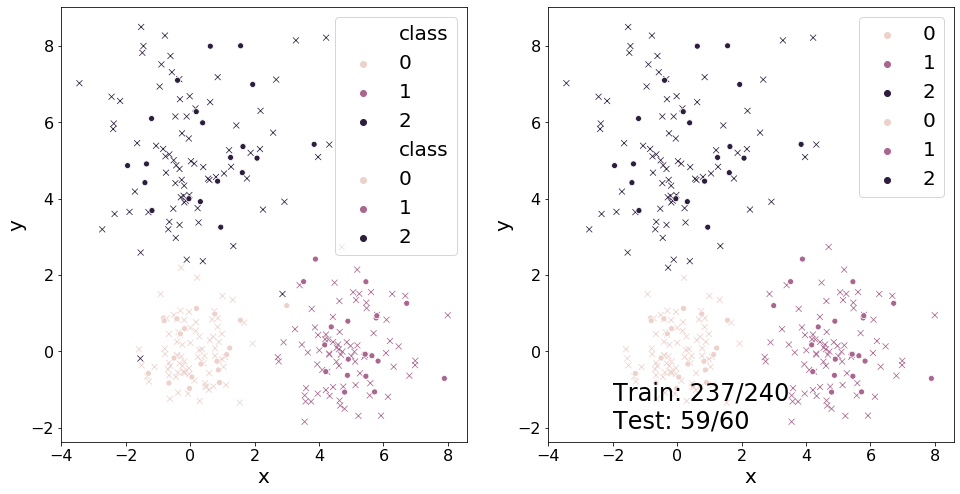

In [11]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.subplot(1, 2, 1)
sns.scatterplot(x=x_train["x"], y=x_train["y"], hue=y_train, marker='x')
sns.scatterplot(x=x_test["x"], y=x_test["y"], hue=y_test)
plt.subplot(1, 2, 2)
sns.scatterplot(x=x_train["x"], y=x_train["y"], hue=y_pred_train, marker='x')
sns.scatterplot(x=x_test["x"], y=x_test["y"], hue=y_pred_test);
plt.text(-2, -2, "Train: %d/%d\nTest: %d/%d" % 
         ((y_train == y_pred_train).sum(), x_train.shape[0], (y_test == y_pred_test).sum(), x_test.shape[0]),
        fontsize=24);

In [22]:
from sklearn.metrics import confusion_matrix

def get_cm(y, y_pred):
    train_cm = confusion_matrix(y, y_pred)

    column_labels = ['class_%d'%i for i in range(1, 4)]

    return pd.DataFrame(train_cm, columns=['pred_'+i for i in column_labels], 
                              index=['true_' + i for i in column_labels])

train_cm_df = get_cm(y_train, y_pred_train)
test_cm_df = get_cm(y_test, y_pred_test)

print('Train data', train_cm_df)

print('\nTest data', test_cm_df)

Train data               pred_class_1  pred_class_2  pred_class_3
true_class_1            79             0             1
true_class_2             0            80             0
true_class_3             1             1            78

Test data               pred_class_1  pred_class_2  pred_class_3
true_class_1            19             1             0
true_class_2             0            20             0
true_class_3             0             0            20


# Gaussian Mixture Models and Expectation Maximization

Here, we demonstrate the fitting of a Gaussian mixture model to the dataset using expectation maximization.

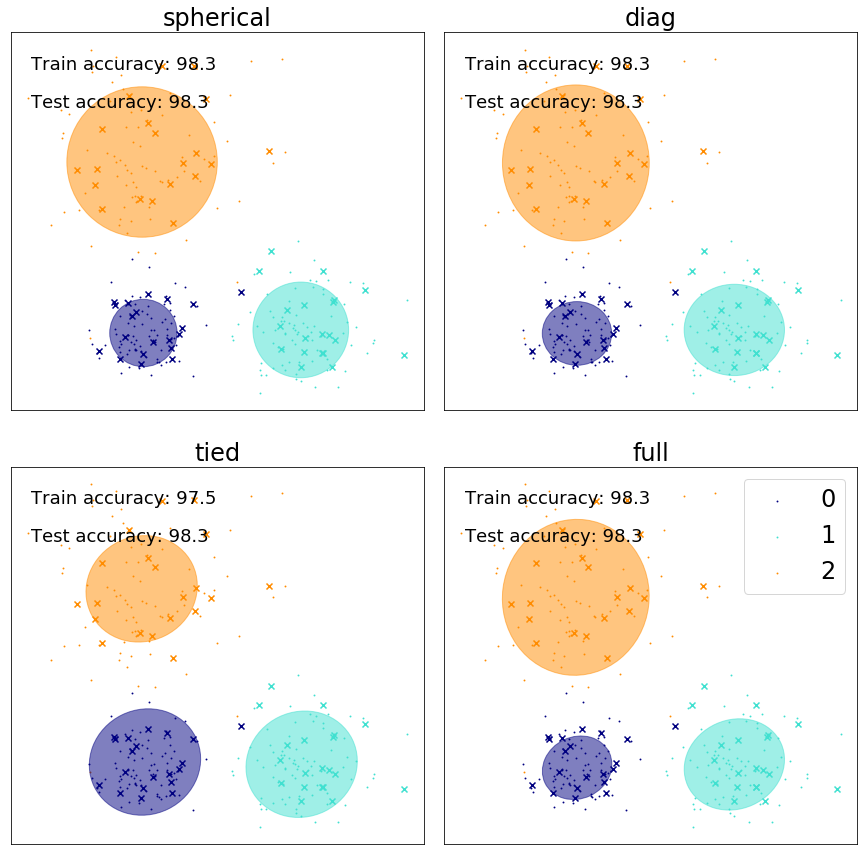

In [23]:
from sklearn.mixture import GaussianMixture

colors = ['navy', 'turquoise', 'darkorange']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = {cov_type: GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(6 * n_estimators // 2, 12))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([x_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(x_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        d = x[y == n]
        plt.scatter(d['x'], d['y'], s=0.8, color=color, label=n)
        d = x_test[y_test == n]
        plt.scatter(d['x'], d['y'], marker='x', color=color)

    y_train_pred = estimator.predict(x_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy, transform=h.transAxes, fontsize=18)

    y_test_pred = estimator.predict(x_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy, transform=h.transAxes, fontsize=18)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='upper right', fontsize=24)

plt.show()